# Приложение для знакомств

In [1]:
import pandas as pd
import numpy as np

import pingouin as pg
import scipy.stats as ss
from scipy.stats import chi2_contingency
from scipy.stats import bootstrap
import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib.pyplot as plt
#импортируем библиотеки

In [2]:
df = pd.read_csv('dating_data.csv')
df
#читаем данные

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1
...,...,...,...,...
14509,476,631,0,0
14510,455,770,1,0
14511,260,6,1,1
14512,885,812,1,1


In [3]:
a = df.shape[0]
b_1 = df['user_id_1'].nunique()
b_2 = df['user_id_2'].nunique()
c_0 = df['group'].value_counts()[0]
c_1 = df['group'].value_counts()[1]
d_0 = df.query('group == 0')['user_id_1'].nunique() + df.query('group == 0')['user_id_2'].nunique()
d_1 = df.query('group == 1')['user_id_1'].nunique() + df.query('group == 1')['user_id_2'].nunique()

print('Всего взаимодействий =', a)
print('Количество пользователей которые взаимодействуют друг с другом (1) =', b_1)
print('Количество пользователей которые взаимодействуют друг с другом(2) =', b_2)
print('Количество взаимодействий в группе со старым алгоритмом =', c_0)
print('Количество взаимодействий в группе с новым алгоритмом =', c_1)
print('Количество пользователей со старым алгоритмом =', d_0)
print('Количество пользователей с новым алгоритмом =', d_1)

Всего взаимодействий = 14514
Количество пользователей которые взаимодействуют друг с другом (1) = 1000
Количество пользователей которые взаимодействуют друг с другом(2) = 1000
Количество взаимодействий в группе со старым алгоритмом = 4792
Количество взаимодействий в группе с новым алгоритмом = 9722
Количество пользователей со старым алгоритмом = 1002
Количество пользователей с новым алгоритмом = 998


__Оценка системы сплитования через проверку на пересечение пользователей из разных групп с помощью множеств__

In [8]:
gr_01 = set(df.query('group==0').user_id_1)
gr_11 = set(df.query('group==1').user_id_1)

gr_01.intersection(gr_11)

set()

In [9]:
gr_02 = set(df.query("group==0")['user_id_2'])
gr_12 = set(df.query("group==1")['user_id_2'])

gr_02.intersection(gr_12)

set()

__Множества не пересекаются__ - пользователи из контрольной группы не могут быть частью тестовой группы

## Гипотеза 1: изменилось соотношение мэтчей и не-мэтчей

In [10]:
df_crosstab = pd.crosstab(df.group, df.is_match)
df_crosstab

is_match,0,1
group,,
0,3858,934
1,5813,3909


In [11]:
exp, obs, stats = pg.chi2_independence(data=df, 
                                       x="group", 
                                       y="is_match") 

In [16]:
stats
# Коэффициент крамера - мера тесноты связи в таблицах сопряженности.
# Коэффициент 0 - независимые переменные
              #1 - зависимые переменные


,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,618.688914,1.0,1.441830e-136,0.206463,1.0
1,cressie-read,0.666667,628.560791,1.0,1.027630e-138,0.208104,1.0
2,log-likelihood,0.000000,652.966812,1.0,5.056969e-144,0.212106,1.0
3,freeman-tukey,-0.500000,675.931262,1.0,5.125545e-149,0.215803,1.0
4,mod-log-likelihood,-1.000000,703.556093,1.0,5.039774e-155,0.220169,1.0
5,neyman,-2.000000,775.869247,1.0,9.519662e-171,0.231207,1.0


In [13]:
cross_data_from_chi = df.groupby(['group','is_match'], as_index = False) \
                                .agg({'user_id_1':'count'}) \
                                .rename(columns={'user_id_1':'count_events'}) \
                                .pivot_table(index='group', columns='is_match', values='count_events')
cross_data_from_chi

is_match,0,1
group,,
0,3858.0,934.0
1,5813.0,3909.0


In [14]:
res_statistic, res_pvalue, res_dof, res_expected_freq = chi2_contingency(cross_data_from_chi)
print('T-statistic =', res_statistic)
print('p-value =', res_pvalue)
print('The degrees of freedom =', res_dof)

T-statistic = 618.6889141576198
p-value = 1.4418299163662586e-136
The degrees of freedom = 1


__Соотношение мэтчей и не-мэтчей изменилось статистически значимо__ (в пользу тестовой группы)

## Гипотеза 2: изменилось число анкет на пользователя

In [17]:
prof_per_user = df.groupby(["group", "user_id_1"], as_index=False).size()
prof_per_user
# Активность взаимодействий пользователей - количество действий (лайк или дизлайк) на пользователя

,group,user_id_1,size
0,0,4,9
1,0,10,6
2,0,12,12
3,0,14,8
4,0,15,20
...,...,...,...
995,1,987,23
996,1,992,21
997,1,993,18
998,1,998,18


<Axes: xlabel='size', ylabel='Count'>

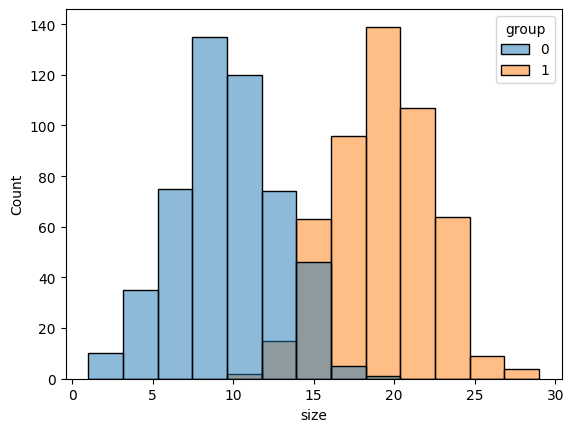

In [18]:
sns.histplot(data=prof_per_user, x="size", hue="group")

In [20]:
pg.ttest(x=prof_per_user.query("group==0")["size"], 
         y=prof_per_user.query("group==1")["size"]) 
#BF10 - насколько альтернативная гипотеза вероятнее нулевой
#CI95% - доверительный интервал различий средних относительно контрольной группы (в контрольной группе в среднем анкет на 10 меньше чем в тестовой группе)
#cohen-d - стандартизованное различие в средних (разница в 3 стандартных отклоненения)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-51.85607,997.694538,two-sided,2.005369e-285,"[-10.29, -9.54]",3.279531,9.827e+280,1.0


In [22]:
pg.mwu(x=prof_per_user.query("group==0")["size"], 
       y=prof_per_user.query("group==1")["size"]) 
#Манн-Уитни показывает, 
# что при схожих распределениях, тест показывает какова вероятность, что  случайно взятые данные из первой группы (контрольной) будут больше данные из второй 
# CLES = 0.01 - 1% вероятности

,U-val,alternative,p-val,RBC,CLES
MWU,3316.0,two-sided,6.905155e-157,0.973472,0.013264


__Число анкет на пользователя изменилось статистически значимо__ (в пользу тестовой группы)

## Гипотеза 3: изменилось число мэтчей на пользователя

In [23]:
matches_per_user = df.query("is_match==1").groupby(["group", "user_id_1"], as_index=False).size()
matches_per_user

,group,user_id_1,size
0,0,4,2
1,0,10,3
2,0,12,1
3,0,15,3
4,0,17,1
...,...,...,...
915,1,987,8
916,1,992,8
917,1,993,6
918,1,998,10


<Axes: xlabel='size', ylabel='Count'>

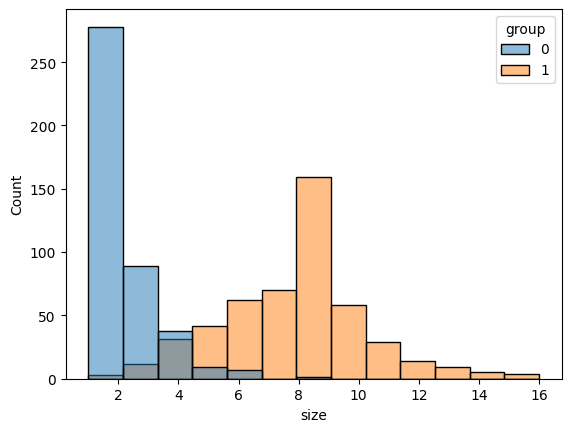

In [24]:
sns.histplot(data=matches_per_user, x="size", hue="group")

In [25]:
pg.ttest(x=matches_per_user.query("group==0")["size"], 
         y=matches_per_user.query("group==1")["size"])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-45.232978,744.211281,two-sided,9.229585e-216,"[-5.88, -5.39]",2.843535,3.166e+231,1.0


In [26]:
pg.mwu(x=matches_per_user.query("group==0")["size"], 
       y=matches_per_user.query("group==1")["size"])

,U-val,alternative,p-val,RBC,CLES
MWU,3944.5,two-sided,1.570060e-141,0.962461,0.018769


Для проверки гипотезы о различиях в распределениях используем метод - тест Колмогорова-Смирнова:

In [28]:
ss.ks_2samp(data1=matches_per_user.query("group==0")["size"], 
            data2=matches_per_user.query("group==1")["size"])

KstestResult(statistic=0.86734616189878, pvalue=7.275661293438345e-179, statistic_location=4, statistic_sign=1)

Модифицированный вариант критерия Манна-Уитни, который проверяет стохастическое доминирование - тест Бруннера-Манцеля:

In [30]:
ss.brunnermunzel(x=matches_per_user.query("group==0")["size"], 
                 y=matches_per_user.query("group==1")["size"])

BrunnerMunzelResult(statistic=138.3937168748187, pvalue=0.0)

__Bootstrap__

**_Доверительный интервал для среднего и медианы_**

In [42]:
bootstrap((matches_per_user.query("group==0")["size"], ), np.mean)
# Среднее от 2.106 до 2.33

BootstrapResult(confidence_interval=ConfidenceInterval(low=2.1018957345971563, high=2.3306069557131748), bootstrap_distribution=array([2.33649289, 2.19905213, 2.37440758, ..., 2.23696682, 2.1492891 ,
       2.18009479]), standard_error=0.05856905762300017)

In [43]:
bootstrap((matches_per_user.query("group==1")["size"], ), np.mean)
# Среднее от 7.634 до 8.07

BootstrapResult(confidence_interval=ConfidenceInterval(low=7.636546184738956, high=8.068273092369479), bootstrap_distribution=array([7.8313253 , 7.89156627, 7.79317269, ..., 7.74698795, 7.88955823,
       7.8935743 ]), standard_error=0.11025859668009161)

In [39]:
bootstrap((matches_per_user.query("group==0")["size"], ), np.median)
# Медиана = 2

C:\Python\Python312\Lib\site-packages\scipy\stats\_resampling.py:149: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\Алмас\AppData\Local\Temp\ipykernel_11528\1528919257.py:1: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  bootstrap((matches_per_user.query("group==0")["size"], ), np.median)


BootstrapResult(confidence_interval=ConfidenceInterval(low=nan, high=nan), bootstrap_distribution=array([2., 2., 2., ..., 2., 2., 2.]), standard_error=0.0)

In [40]:
bootstrap((matches_per_user.query("group==1")["size"], ), np.median)
# Медиана = 8

C:\Python\Python312\Lib\site-packages\scipy\stats\_resampling.py:149: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\Алмас\AppData\Local\Temp\ipykernel_11528\2812672564.py:1: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  bootstrap((matches_per_user.query("group==1")["size"], ), np.median)


BootstrapResult(confidence_interval=ConfidenceInterval(low=nan, high=nan), bootstrap_distribution=array([8., 8., 8., ..., 8., 8., 8.]), standard_error=0.059044523937592956)

**_Доверительный интервал для  различий в среднем и медиане_**

In [45]:
ss.bootstrap([matches_per_user.query("group==0")["size"], 
              matches_per_user.query("group==1")["size"]], 
             statistic=lambda x, y: np.mean(x) - np.mean(y))
# Доверительный интервал для различий в средних составляет [-5.88; 5.39]

BootstrapResult(confidence_interval=ConfidenceInterval(low=-5.885210431220977, high=-5.398827590194425), bootstrap_distribution=array([-5.64222768, -5.80951293, -5.8575344 , ..., -5.57503949,
       -5.72753574, -5.42038295]), standard_error=0.1247560717775309)

In [44]:
ss.bootstrap([matches_per_user.query("group==0")["size"], 
              matches_per_user.query("group==1")["size"]], 
             statistic=lambda x, y: np.median(x) - np.median(y)) 
# Доверительный интервал для различий в медиане составляет [-6]

C:\Python\Python312\Lib\site-packages\scipy\stats\_resampling.py:149: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\Алмас\AppData\Local\Temp\ipykernel_11528\499326604.py:1: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  ss.bootstrap([matches_per_user.query("group==0")["size"],


BootstrapResult(confidence_interval=ConfidenceInterval(low=nan, high=nan), bootstrap_distribution=array([-6., -6., -6., ..., -6., -6., -6.]), standard_error=0.059044523937592956)

In [34]:
pg.compute_bootci(matches_per_user.query("group==0")["size"], 
                  matches_per_user.query("group==1")["size"], 
                  func=lambda x, y: np.median(x) - np.median(y)) #cper, медианы

array([-6., -6.])

In [35]:
pg.compute_bootci(matches_per_user.query("group==0")["size"], 
                  matches_per_user.query("group==1")["size"], 
                  func=lambda x, y: np.mean(x) - np.mean(y)) #cper, средние

array([-5.88, -5.37])

__Регрессионная модель__

In [47]:
results = smf.ols('is_match ~ group', df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               is_match   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     647.2
Date:                Sun, 01 Sep 2024   Prob (F-statistic):          1.04e-139
Time:                        15:01:12   Log-Likelihood:                -9366.5
No. Observations:               14514   AIC:                         1.874e+04
Df Residuals:                   14512   BIC:                         1.875e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1949      0.007     29.243      0.0

### Бутстрап и сравнение квантилей

C:\Python\Python312\Lib\site-packages\pingouin\plotting.py:818: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.stripplot(
C:\Python\Python312\Lib\site-packages\pingouin\plotting.py:869: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(["Y", "X"], size=15)


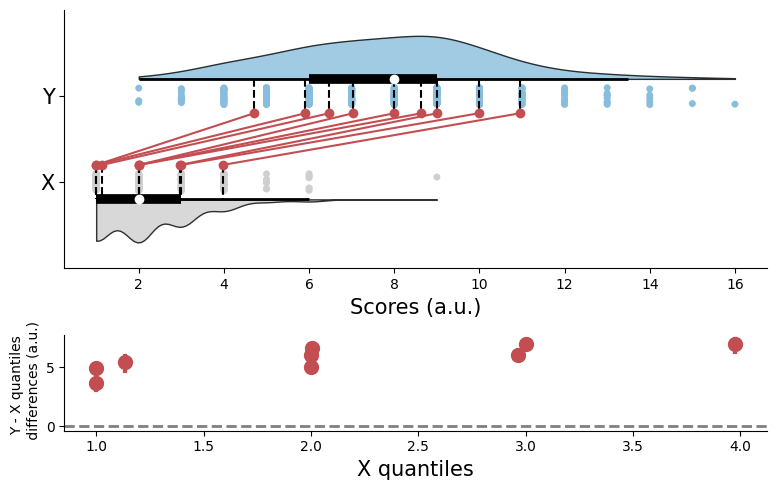

In [46]:
pg.plot_shift(matches_per_user.query("group==0")["size"], 
              matches_per_user.query("group==1")["size"])
plt.show()

__Число мэтчей на пользователя изменилось статистически значимо__ (в пользу тестовой группы)

## Вывод : вводим новые алгоритмы для приложения знакомств